In [65]:
import numpy as np
import matplotlib.pyplot as plt
import math

def generate_points_within_cell(cell_x, cell_y, totalPoints):
    """
    Generate points within a 1x1 cell arranged in a grid pattern.

    Parameters:
    - cell_x, cell_y: Coordinates of the bottom-left corner of the cell.
    - num_points_per_side: Number of points along each side of the grid (default is 3 for 3x3).
    - padding: Space from the cell borders to the outermost points.

    Returns:
    - List of (x, y) tuples representing point coordinates.
    """
    padding=0.25
    num_points_per_side = max(2, math.ceil(np.sqrt(totalPoints)))
    drawnPoints = 0

    points = []
    spacing = (1 - 2 * padding) / (num_points_per_side - 1)
    for i in range(num_points_per_side):
        for j in range(num_points_per_side):
            x = cell_x + padding + j * spacing
            y = cell_y + padding + i * spacing
            points.append((x, y))

            drawnPoints += 1
            if drawnPoints >= totalPoints:
                break
        if drawnPoints >= totalPoints:
            break
    return points

def collectAllPoints(area):
# Collect all points from the grid
    all_points = []
    all_temperatures = []

    for row in area:
        for cell in row:
            cell_points = generate_points_within_cell(cell.x, cell.y, len(cell.particles))
            all_points.extend(cell_points)
            all_temperatures.extend(map(lambda c: c.temp, cell.particles))

    # Separate x and y coordinates for plotting
    x_coords, y_coords = zip(*all_points)

    return x_coords, y_coords, all_temperatures

def getCellText(cell):
    return f'T:{math.floor(cell.getTemp())} D:{len(cell.particles)}'


def drawPlot(area):
    x_coords, y_coords, all_temperatures = collectAllPoints(area)

    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(8, 8))

    # Plot the 1x1 grid cells as squares
    for i in range(len(area)):
        for j in range(len(area[i])):
            square = plt.Rectangle((i, j), 1, 1, edgecolor='black', facecolor='none', linewidth=0.5)
            ax.add_patch(square)
            ax.text(i+0.5, j+0.5, getCellText(area[len(area[i])-1-j][i]), ha='center', va='center', fontsize=6, color='black')

    # Create a scatter plot with temperature-based colors
    scatter = ax.scatter(x_coords, y_coords, c=all_temperatures, cmap='coolwarm', vmin=15, vmax=30, s=50)

    # plt.clim(15,30)

    # Add a color bar to show temperature scale
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label('Temperature (°C)')

    # Set axis limits
    ax.set_xlim(0, 10)
    ax.set_ylim(0, 10)

    # Set labels and title
    ax.set_xlabel('X Coordinate')
    ax.set_ylabel('Y Coordinate')
    # ax.set_title('2D Grid with 9 Points per Cell Colored by Temperature')

    # Set aspect of the plot to be equal
    ax.set_aspect('equal')

    # Show the plot
    plt.show()

In [66]:
class Particle:
    def __init__(self, temp):
        self.temp = temp
        self.state = 'liquid'

class Spatial2dArea:
    def __init__(self, x, y, temp, numParticles):
        self.x = x
        self.y = y
        self.particles = [Particle(temp) for i in range(numParticles)]

    def __str__(self):
        return f"[({self.x}, {self.y}), Particles: {len(self.particles)})]"

    def removeLastParticle(self):
        return self.particles.pop()

    def removeNParticles(self, n):
        if n > len(self.particles):
            raise ValueError("Cannot remove more particles than available.")
        return [self.particles.pop() for i in range(n)]

    def heatUpParticles(self, inc):
        for i in self.particles:
            i.temp += inc
        return self.particles

    # Adding particles to another cell averages out the temp to simulate heat transfer
    def extendParticles(self, particles):
        self.particles.extend(particles)
        avgTemp = sum(map(lambda p: p.temp, self.particles)) / len(self.particles)

        for i in self.particles:
            i.temp = avgTemp

        return avgTemp

    def getTemp(self):
        if len(self.particles) == 0:
            raise ValueError("No particles exist in this cell.")
        return self.particles[0].temp


def getWaterLevel(areaList):
    return areaList[-1]

def printAreaRow(areaRow):
    line = ''
    for i in areaRow:
        line += str(i) + ' '
    print(line)

def printFullAreaList(areaList):
    for row in areaList:
        printAreaRow(row)

# bottom left is 0,0 - top right is 9,9
def initializeAreaGrid():
    return [[Spatial2dArea(i, j, 24-j*2, 30-j) for i in range(9+1)] for j in range(9, -1, -1)]

def heatUpWater(area, increment):
    waterLevel = getWaterLevel(area)
    for i in waterLevel:
        i.temp += increment
        for j in i.particles:
            j.temp += increment
    return area

def createLowPressureZone(area, lowerXBound, upperXBound, numParticles):
    for i in range(0, len(area)-1):
        row = area[i]
        spatialSlice = row[lowerXBound:upperXBound+1]

        for cell in spatialSlice:
            cell.particles = [Particle(cell.temp) for _ in range(numParticles+i)]

    return area

def heatMiddleOfWater(area, increment):
    for cell in areaGrid[-1][4:6]:
        cell.heatUpParticles(increment)

    return area


In [67]:
'''
water evaporation depends on:
- temp diff
- pressure - normal pressure @ water is 210 with my current setup
'''

def getYIdx(area, y, *args):
    yArgs = [y]
    yArgs.extend(args)
    idx = []
    for i in yArgs:
        idx.append(len(area)-1-i)

    if len(idx) == 1:
        return idx[0]
    return idx

def evaporateParticles(area, x, y0, y1, numParticles):
    print(f'Evaporating from {x}, {y0} to {y1} with {numParticles} num')
    y0Idx, y1Idx = getYIdx(area, y0, y1)

    evaporatingParticles = area[y0Idx][x].removeNParticles(numParticles)

    # adiabatic cooling to lose temp as air rises
    for i in evaporatingParticles:
        i.temp -= 1

    # temp gets avged out for heat transfer
    area[y1Idx][x].extendParticles(evaporatingParticles)

    return area

# assuming that every increase in altitude decreases temp by 1.
# if temp diff greater than 1
def getTempDiff(area, x0, y0, x1, y1):
    y0Idx, y1Idx = getYIdx(area, y0, y1)

    return area[y0Idx][x0].getTemp() - area[y1Idx][x1].getTemp() - 1

def getPressureDiff(area, x0, y0, x1, y1):
    y0Idx, y1Idx = getYIdx(area, y0, y1)

    # to do: if pressure in col is greater than normal
    # pressureInCell = len(area[y0Idx][x].particles)
    # pressureInCol = 0
    # for i in range(y0+1, len(area)):
    #     pressureInCol += len(i[i][x].particles)

    return len(area[y0Idx][x0].particles) - len(area[y1Idx][x1].particles)


# difference between temp + pressure of y
# threshold for evaportion is arbritary 3
# evaporating from y0 TO y1
def numParticlesEvaporating(area, x, y0, y1):
    tempDiff = math.floor(abs(getTempDiff(area, x, y0, x, y1)))
    pressureDiff = max(0, getPressureDiff(area, x, y0, x, y1))
    sumOfFactors = tempDiff + pressureDiff - 3
    numEvaporating = max(0, sumOfFactors)
    return numEvaporating


def handleEvaporation(area):
    for y in range(len(area)-1, 0, -1):
        for x in range(len(area[y])):
            numParticles = numParticlesEvaporating(area, x, y-1, y)
            if numParticles > 0:
                area = evaporateParticles(area, x, y-1, y, numParticles)
    return area

In [68]:
def sidewaysPressureDispersal(area, x0, x1, y, numParticles):
    print(f'Dispersing from {x0}, {y} to {x1} with {numParticles} num')

    yIdx = getYIdx(area, y)
    print(yIdx)

    dispersedParticles = area[yIdx][x0].removeNParticles(numParticles)

    area[yIdx][x1].extendParticles(dispersedParticles)

    return area

# arbitrary threshold of 2 to have pressure dispersal
def numParticlesPressureDispersing(area, x0, x1, y):
    # if temp diff, then air should be rising
    if getTempDiff(area, x0, y, x1, y) > 0:
        return 0

    # arb threshold of 2 to have movement
    pressureDiff = getPressureDiff(area, x0, y, x1, y) - 2
    numDispersing = max(0, pressureDiff)
    return numDispersing

def handlePressureDispersal(area):
    for y in range(len(area)):
        leftCenter = math.floor(len(area[y])/2)
        rightCenter = math.ceil(len(area[y])/2)

        for x in range(leftCenter, 0, -1):
            numParticles = numParticlesPressureDispersing(area, x, x-1, y)
            if numParticles > 0:
                area = sidewaysPressureDispersal(area, x, x-1, y, numParticles)

        for x in range(rightCenter, len(area[y])-1):
            numParticles = numParticlesPressureDispersing(area, x, x+1, y)
            if numParticles > 0:
                area = sidewaysPressureDispersal(area, x, x+1, y, numParticles)

    return area


[(0, 9), Particles: 21)] [(1, 9), Particles: 21)] [(2, 9), Particles: 21)] [(3, 9), Particles: 21)] [(4, 9), Particles: 21)] [(5, 9), Particles: 21)] [(6, 9), Particles: 21)] [(7, 9), Particles: 21)] [(8, 9), Particles: 21)] [(9, 9), Particles: 21)] 
[(0, 8), Particles: 22)] [(1, 8), Particles: 22)] [(2, 8), Particles: 22)] [(3, 8), Particles: 22)] [(4, 8), Particles: 22)] [(5, 8), Particles: 22)] [(6, 8), Particles: 22)] [(7, 8), Particles: 22)] [(8, 8), Particles: 22)] [(9, 8), Particles: 22)] 
[(0, 7), Particles: 23)] [(1, 7), Particles: 23)] [(2, 7), Particles: 23)] [(3, 7), Particles: 23)] [(4, 7), Particles: 23)] [(5, 7), Particles: 23)] [(6, 7), Particles: 23)] [(7, 7), Particles: 23)] [(8, 7), Particles: 23)] [(9, 7), Particles: 23)] 
[(0, 6), Particles: 24)] [(1, 6), Particles: 24)] [(2, 6), Particles: 24)] [(3, 6), Particles: 24)] [(4, 6), Particles: 24)] [(5, 6), Particles: 24)] [(6, 6), Particles: 24)] [(7, 6), Particles: 24)] [(8, 6), Particles: 24)] [(9, 6), Particles: 24

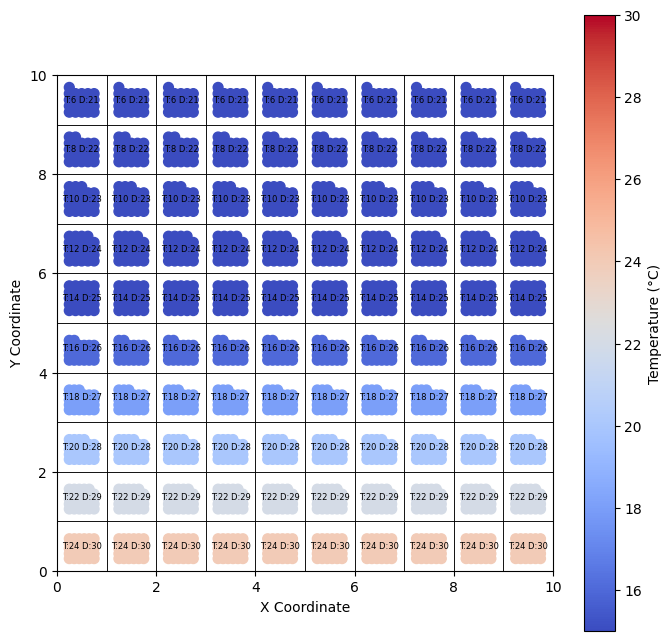

In [69]:
areaGrid = initializeAreaGrid()
printFullAreaList(areaGrid)
drawPlot(areaGrid)

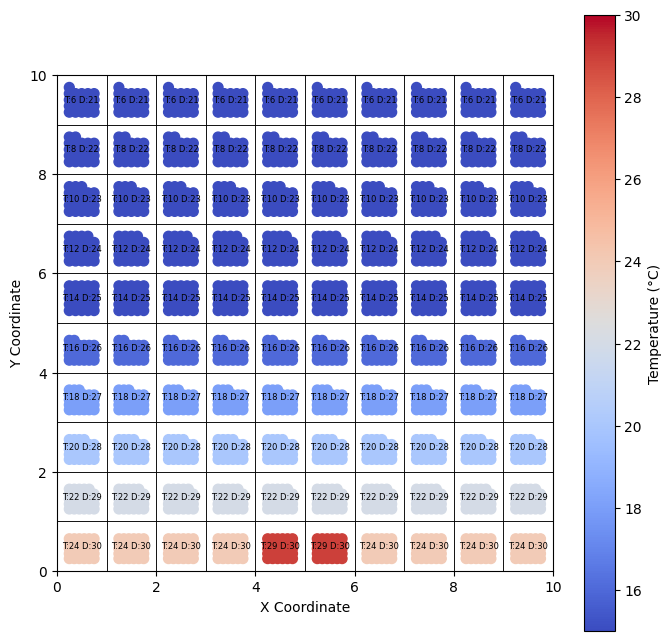

In [70]:
areaGrid = heatMiddleOfWater(areaGrid, 5)
drawPlot(areaGrid)

Evaporating from 4, 0 to 1 with 4 num
Evaporating from 5, 0 to 1 with 4 num


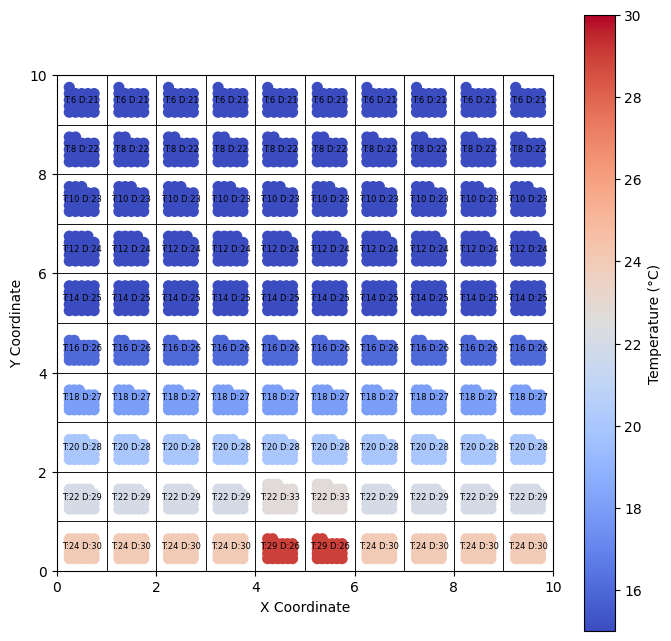

In [71]:
areaGrid = handleEvaporation(areaGrid)
drawPlot(areaGrid)

Evaporating from 4, 1 to 2 with 3 num
Evaporating from 5, 1 to 2 with 3 num
Evaporating from 4, 0 to 1 with 2 num
Evaporating from 5, 0 to 1 with 2 num


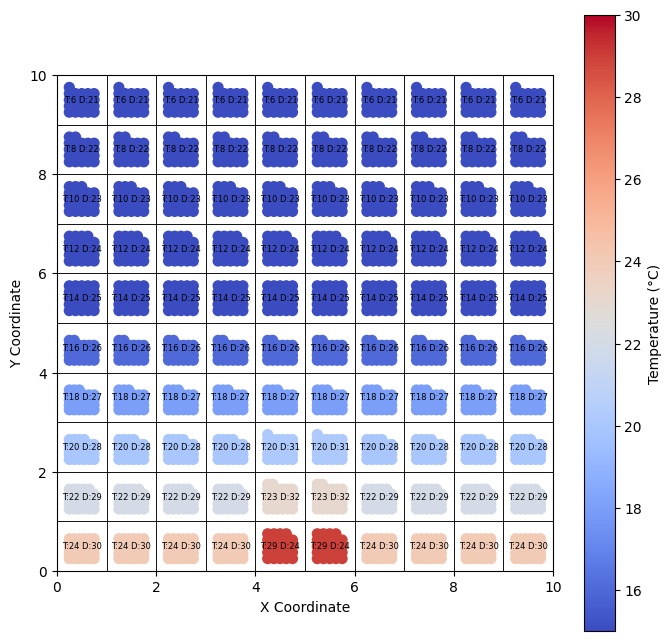

In [72]:
areaGrid = handleEvaporation(areaGrid)
drawPlot(areaGrid)

Evaporating from 4, 2 to 3 with 2 num
Evaporating from 5, 2 to 3 with 2 num
Evaporating from 4, 1 to 2 with 1 num
Evaporating from 5, 1 to 2 with 1 num
Evaporating from 4, 0 to 1 with 1 num
Evaporating from 5, 0 to 1 with 1 num


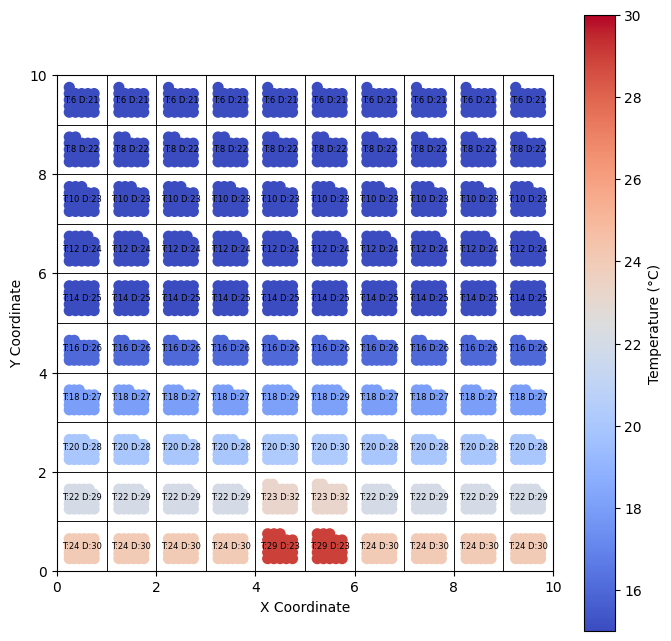

In [73]:
areaGrid = handleEvaporation(areaGrid)
drawPlot(areaGrid)

Critique: As the air rises, I'm showing the air moving to the cell above. When air rises, it displaces the air above it. The displaced air moves downwards or sideways.

Evaporating from 4, 3 to 4 with 1 num
Evaporating from 5, 3 to 4 with 1 num
Evaporating from 4, 0 to 1 with 1 num
Evaporating from 5, 0 to 1 with 1 num


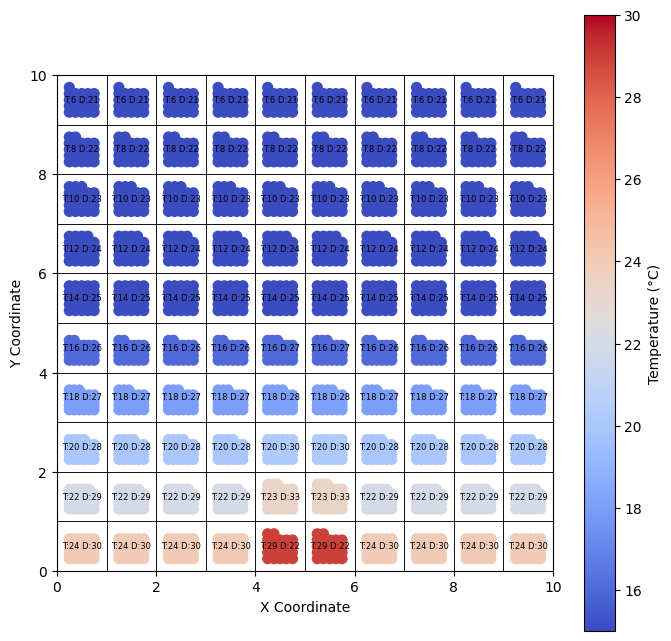

In [74]:
areaGrid = handleEvaporation(areaGrid)
drawPlot(areaGrid)

Evaporating from 4, 1 to 2 with 2 num
Evaporating from 5, 1 to 2 with 2 num
Evaporating from 4, 0 to 1 with 1 num
Evaporating from 5, 0 to 1 with 1 num


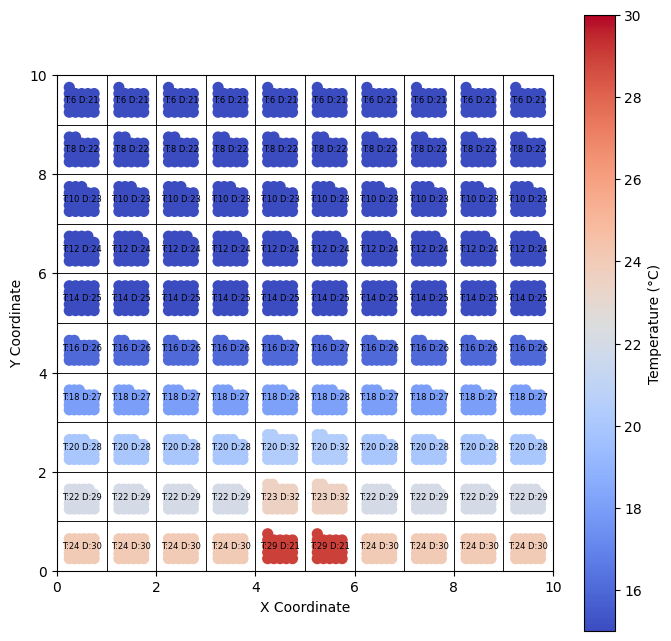

In [75]:
areaGrid = handleEvaporation(areaGrid)
drawPlot(areaGrid)

Evaporating from 4, 2 to 3 with 2 num
Evaporating from 5, 2 to 3 with 2 num
Evaporating from 4, 1 to 2 with 1 num
Evaporating from 5, 1 to 2 with 1 num
Evaporating from 4, 0 to 1 with 1 num
Evaporating from 5, 0 to 1 with 1 num


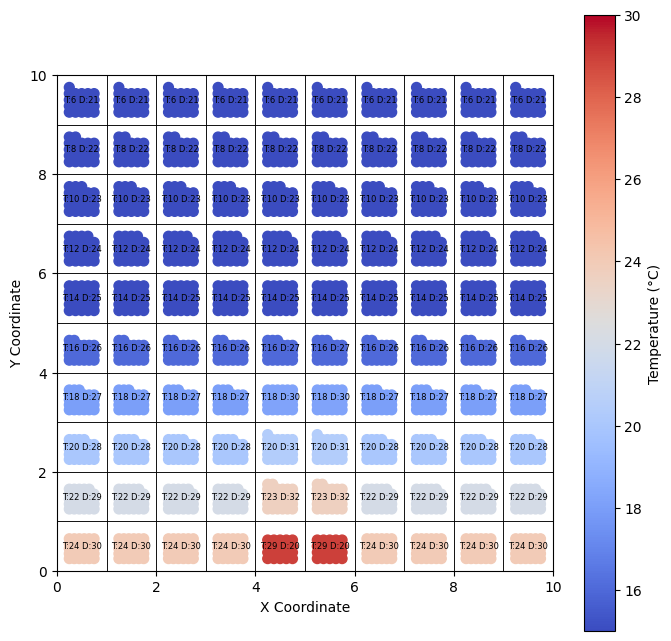

In [76]:
areaGrid = handleEvaporation(areaGrid)
drawPlot(areaGrid)

Evaporating from 4, 3 to 4 with 1 num
Evaporating from 5, 3 to 4 with 1 num
Evaporating from 4, 0 to 1 with 1 num
Evaporating from 5, 0 to 1 with 1 num


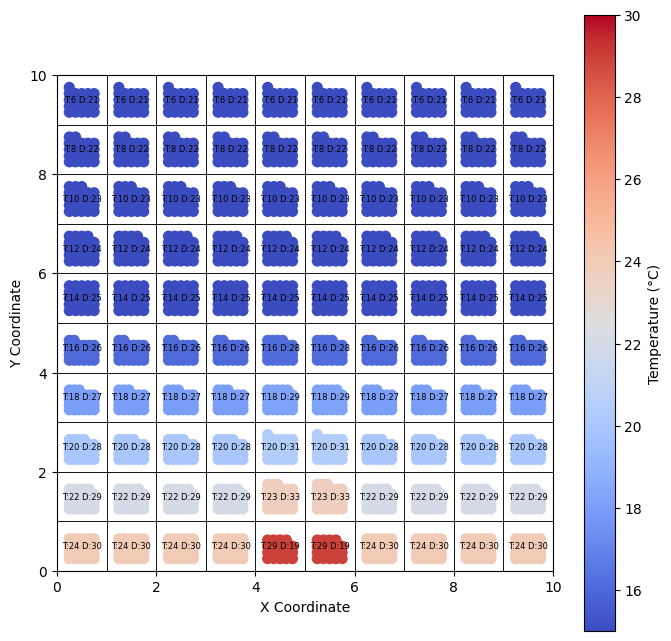

In [77]:
areaGrid = handleEvaporation(areaGrid)
drawPlot(areaGrid)

Evaporating from 4, 4 to 5 with 1 num
Evaporating from 5, 4 to 5 with 1 num
Evaporating from 4, 1 to 2 with 1 num
Evaporating from 5, 1 to 2 with 1 num
Evaporating from 4, 0 to 1 with 1 num
Evaporating from 5, 0 to 1 with 1 num


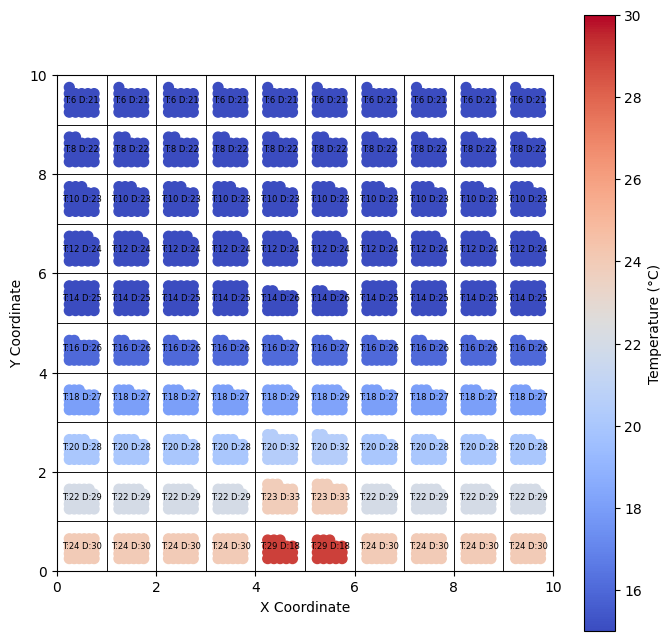

In [78]:
areaGrid = handleEvaporation(areaGrid)
drawPlot(areaGrid)

Evaporating from 4, 2 to 3 with 1 num
Evaporating from 5, 2 to 3 with 1 num
Evaporating from 4, 1 to 2 with 1 num
Evaporating from 5, 1 to 2 with 1 num
Evaporating from 4, 0 to 1 with 1 num
Evaporating from 5, 0 to 1 with 1 num


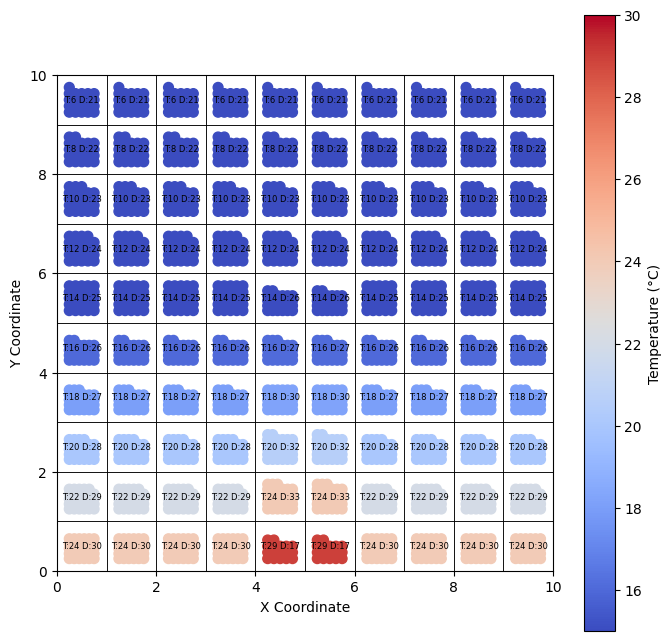

In [79]:
areaGrid = handleEvaporation(areaGrid)
drawPlot(areaGrid)

Evaporating from 4, 3 to 4 with 1 num
Evaporating from 5, 3 to 4 with 1 num
Evaporating from 4, 2 to 3 with 1 num
Evaporating from 5, 2 to 3 with 1 num
Evaporating from 4, 1 to 2 with 1 num
Evaporating from 5, 1 to 2 with 1 num


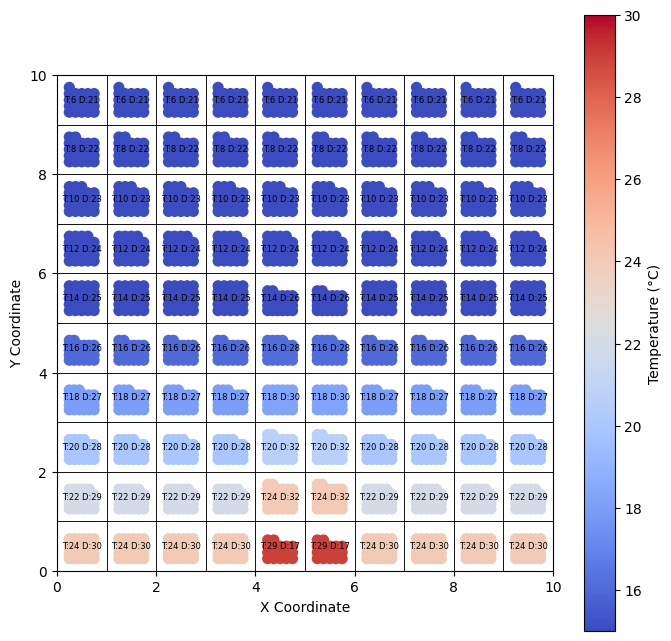

In [80]:
areaGrid = handleEvaporation(areaGrid)
drawPlot(areaGrid)

Dispersing from 4, 2 to 3 with 2 num
7
Dispersing from 5, 2 to 6 with 2 num
7
Dispersing from 4, 3 to 3 with 1 num
6
Dispersing from 5, 3 to 6 with 1 num
6


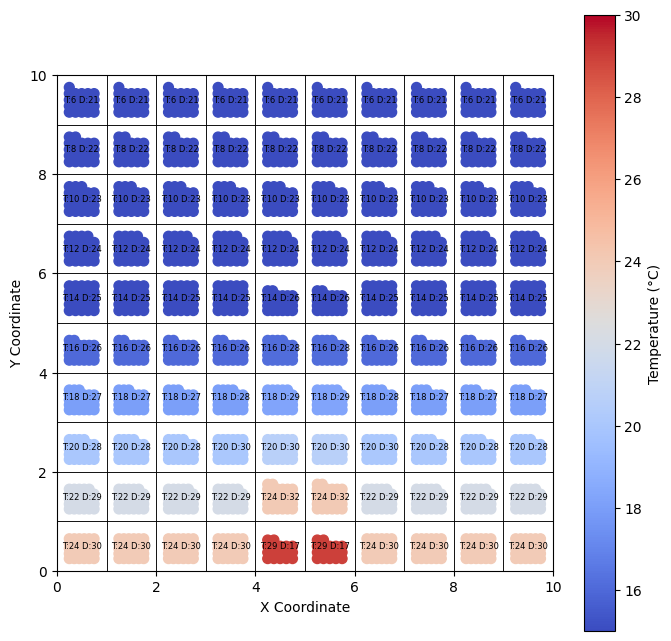

In [81]:
areaGrid = handlePressureDispersal(areaGrid)
drawPlot(areaGrid)